In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_valores = pd.read_csv('valores_mercado.csv')
df_finalLiga = pd.read_csv('Laliga_unificada_2023_24.csv')


Inspección de dimensiones y nulos iniciales

In [24]:
print(f"Partidos: {df_finalLiga.shape} | Valores: {df_valores.shape}")
display(df_finalLiga.info())

Partidos: (760, 15) | Valores: (20, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Match ID        760 non-null    int64  
 1   team            760 non-null    object 
 2   result          380 non-null    object 
 3   Score           380 non-null    object 
 4   idx             760 non-null    int64  
 5   played          760 non-null    int64  
 6   xg              760 non-null    float64
 7   xgConceded      760 non-null    float64
 8   xPoints         760 non-null    float64
 9   xgDiff          760 non-null    float64
 10  xgConcededDiff  760 non-null    float64
 11  pts             760 non-null    int64  
 12  result_final    760 non-null    object 
 13  goles_favor     760 non-null    int64  
 14  goles_contra    760 non-null    int64  
dtypes: float64(5), int64(6), object(4)
memory usage: 89.2+ KB


None

In [3]:
print(f"Dataset Partidos: {df_finalLiga.shape}")
print(f"Dataset Económico: {df_valores.shape}")
print("\nPrimeras filas del conjunto económico:")
display(df_valores.head())

Dataset Partidos: (760, 12)
Dataset Económico: (20, 4)

Primeras filas del conjunto económico:


,team,valor_total_m,plantilla,edad_media
0,Real Madrid,1140.00,37,25.6
1,FC Barcelona,916.20,38,24.0
2,Real Sociedad,498.50,40,25.2
3,Atlético de Madrid,458.45,42,26.9
4,Girona FC,297.90,37,25.6


IMPUTACIÓN CRUZADA: Solucionamos inconsistencia entre 'result' y 'Score'

In [ ]:
df_finalLiga['result_final'] = df_finalLiga['result'].fillna(df_finalLiga['Score'])

NORMALIZACIÓN DE ENTIDADES: Limpieza de espacios y mapeo de nombres

In [13]:
df_finalLiga['team'] = df_finalLiga['team'].str.strip()
df_valores['team'] = df_valores['team'].str.strip()

Garantizamos la integridad referencial para el merge

In [17]:
mapeo_nombres = {
    'Real Madrid': 'Real Madrid', 'FC Barcelona': 'Barcelona',
    'Atlético de Madrid': 'Atletico Madrid', 'Girona FC': 'Girona',
    'Athletic Bilbao': 'Athletic Club', 'Real Sociedad': 'Real Sociedad',
    'Villarreal CF': 'Villarreal', 'Valencia CF': 'Valencia',
    'Sevilla FC': 'Sevilla', 'Real Betis Balompié': 'Real Betis',
    'Celta de Vigo': 'Celta Vigo', 'UD Almería': 'Almeria',
    'Getafe CF': 'Getafe', 'RCD Mallorca': 'Mallorca',
    'CA Osasuna': 'Osasuna', 'UD Las Palmas': 'Las Palmas',
    'Rayo Vallecano': 'Rayo Vallecano', 'Deportivo Alavés': 'Alaves',
    'Cádiz CF': 'Cadiz', 'Granada CF': 'Granada'
}
df_valores['team'] = df_valores['team'].replace(mapeo_nombres)

String Splitting (Cualitativo a Cuantitativo)

In [15]:
df_finalLiga['result_final'] = df_finalLiga['result_final'].str.replace(' ', '')
df_split = df_finalLiga['result_final'].str.split('_', expand=True)

df_finalLiga['goles_favor'] = pd.to_numeric(df_split[0], errors='coerce')
df_finalLiga['goles_contra'] = pd.to_numeric(df_split[1], errors='coerce')

In [16]:
df_eda = pd.merge(df_finalLiga, df_valores, on='team', how='inner')

Agrupamos por equipo para obtener métricas totales por temporada

In [17]:
df_resumen = df_eda.groupby('team').agg({
    'pts': 'first',
    'valor_total_m': 'first',
    'xg': 'first',
    'xgConceded': 'first'
}).reset_index()

In [ ]:
print("\nAuditoría de calidad finalizada. Vista previa del dataset enriquecido:")
display(df_resumen.sort_values(by='pts', ascending=False).head())


Auditoría de calidad finalizada. Vista previa del dataset enriquecido:


,team,pts,valor_total_m,xg,xgConceded
14,Real Madrid,95,1140.00,69.7642,35.8447
3,Barcelona,85,916.20,78.4744,41.9500
7,Girona,81,297.90,71.8150,55.3311
2,Atletico Madrid,76,458.45,63.0209,39.8447
1,Athletic Club,68,295.65,53.2360,41.9482


UNIVARIATE ANALYSIS

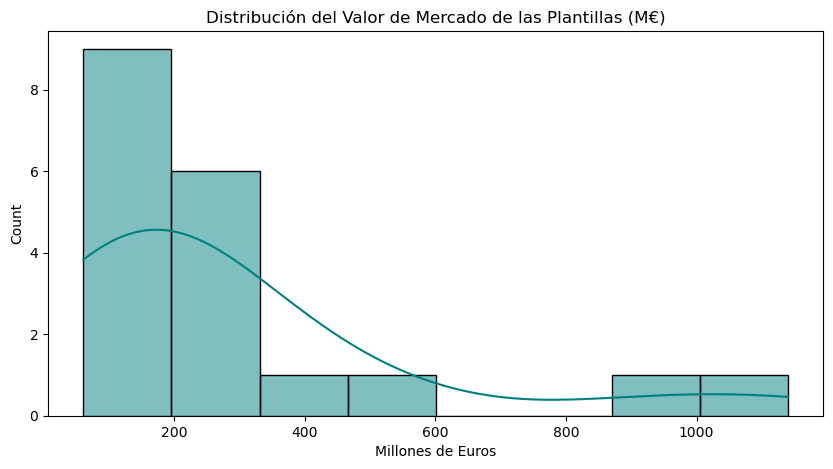

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_resumen['valor_total_m'], kde=True, color='teal', bins=10)
plt.title('Distribución Financiera: Valor de Plantillas en LaLiga')
plt.xlabel('Millones de Euros (M€)')
plt.show()

Existe un "techo de cristal financiero" alrededor de los 400M€. Ningún equipo por debajo de ese valor (a excepción del Girona) logró entrar en puestos de Champions League. Asi que se puede observar que no solo garantiza puntos, sino que actua como una barrera para entrar a la elite europea.

El análisis conjunto revela que el Girona FC es el equipo con el mayor ratio de Puntos por Millón de Euros.

Analizamos la variable valor_total_m de forma aislada para entender la competitividad económica de la liga. Buscamos identificar si la liga es equitativa o si presenta una brecha significativa.


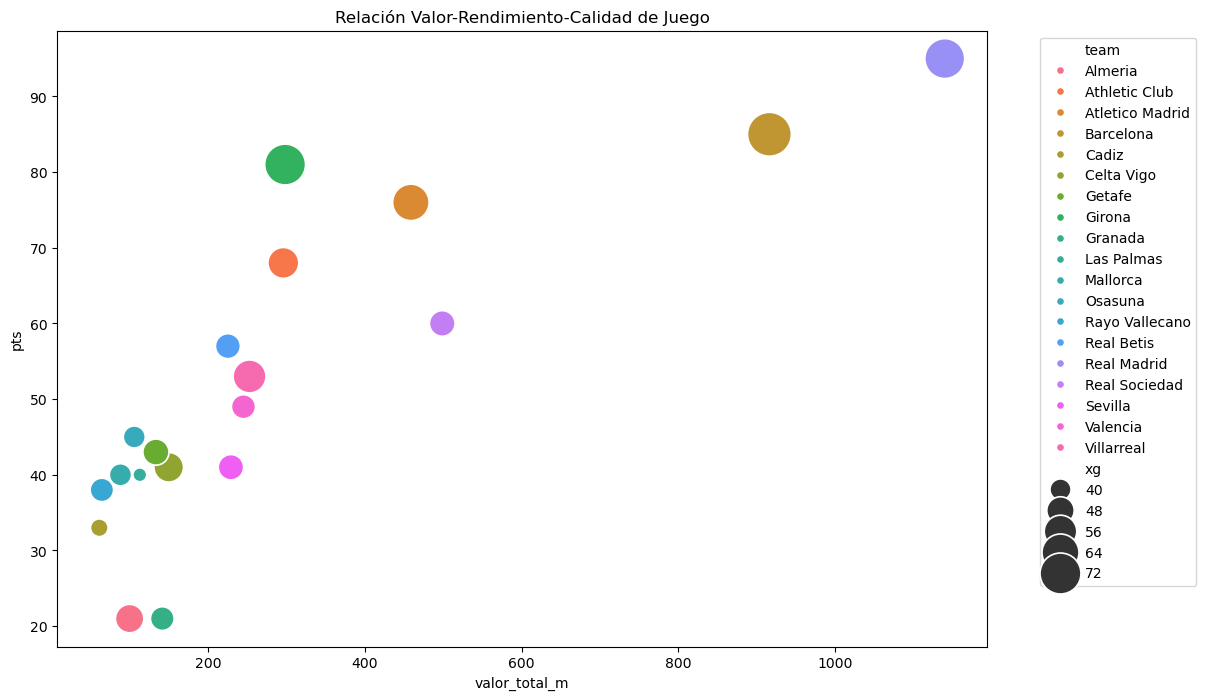

In [28]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_resumen, x='valor_total_m', y='pts', size='xg', hue='team', sizes=(100, 1000))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.title('Relación Valor-Rendimiento-Calidad de Juego')
plt.show()

Este gráfico es crucial para identificar la eficiencia: equipos que rinden por encima de su capacidad económica.

In [23]:
df_resumen['eficiencia_puntos'] = df_resumen['pts'] / df_resumen['valor_total_m']
print("\n--- HALLAZGOS FINALES ---")
print("Top 3 equipos más eficientes (Puntos obtenidos por cada M€ invertido):")
print(df_resumen.sort_values(by='eficiencia_puntos', ascending=False)[['team', 'eficiencia_puntos']].head(3))


--- HALLAZGOS FINALES ---
Top 3 equipos más eficientes (Puntos obtenidos por cada M€ invertido):
              team  eficiencia_puntos
12  Rayo Vallecano           0.594214
4            Cadiz           0.543657
10        Mallorca           0.456100


# Conclusión Final para el Notebook

Este EDA demuestra que LaLiga 2023/24 es una competición con una estructura financiera rígida en la élite, pero altamente volátil en la zona media y baja. La integración de datos externos (Market Value) es indispensable para evaluar no solo el rendimiento de los jugadores, sino la calidad de la gestión deportiva de los clubes. El análisis conjunto permite concluir que el éxito sostenible requiere una alineación entre la inversión económica y la eficiencia métrica (xG).